In [1]:
#imports and settings
import sqlite3
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
pd.options.display.max_columns = 999
plt.style.use('bmh')

In [2]:
conn = sqlite3.connect('/Users/tburch/Documents/Datasets/jazz/wjazzd.db')

## Doing a look into 'I got it bad'

But first, I need to make sure I've got it...

In [32]:
# Songs
query = "SELECT * FROM composition_info WHERE compid IS 6"
song_info = pd.read_sql_query(query, conn)
song_info.head()


,compid,title,composer,form,template,tonalitytype,genre
0,6,I Got It Bad,Ellington/Webster,A8A8B8A8,,FUNCTIONAL,GREAT AMERICAN SONGBOOK


Okay, so there's 2 versions of "stardust" before this. comp_id drops the doubl, so index for "I got it bad is 6"

Is it the same for melid?

In [28]:
# Melody db
query = "SELECT * FROM melody WHERE melid IS 6"
song_melody = pd.read_sql_query(query, conn)
# Check the first few notes
print song_melody.pitch.head().apply(pretty_midi.note_number_to_name)

0    A#3
1    A#4
2    A#3
3    A#4
4    G#4
Name: pitch, dtype: object


Nope. Song goes G, Ab, G, Bb, Ab

In [29]:
# Melody db
query = "SELECT * FROM melody WHERE melid IS 7"
song_melody = pd.read_sql_query(query, conn)
# Check the first few notes
print song_melody.pitch.head().apply(pretty_midi.note_number_to_name)

0     G3
1    G#3
2     G4
3    A#4
4    G#4
Name: pitch, dtype: object


That's it, so melid doesn't have the other one dropped.

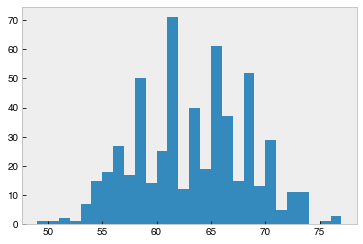

In [75]:
pitch_range = song_melody.pitch.max()-song_melody.pitch.min()
ax= song_melody.pitch.hist(bins=int(pitch_range))
ax.grid(False)

In [73]:
# Probably a better way to do this?
pitches = song_melody.pitch.value_counts().nlargest(5).index
counts = song_melody.pitch.value_counts().nlargest(5).values
for i, c in zip(pitches, counts):
    print pretty_midi.note_number_to_name(i), " occurs ", c, " times"

C#4  occurs  71  times
F4  occurs  61  times
G#4  occurs  52  times
A#3  occurs  50  times
D#4  occurs  40  times


Looking at the sheet music, key is Dbmaj.

Root, Db4 occurs the most (71)

Third, F4 occurs second most (61)

Fifth, Ab4 occurs third most (52)

bSeven, Bb3 occurs fourth most (50)

Second/ninth, Eb4 occurs fifth most (40)

This all makes a lot of sense. Would be nice to write a function to get these all in the same range

In [91]:
def same_range(value):
    while (value > 12): value -=12
    return int(value)

In [95]:
song_melody['normalized_pitch'] = song_melody.pitch.apply(same_range)
song_melody.head()

,eventid,melid,onset,pitch,duration,period,division,bar,beat,tatum,subtatum,num,denom,beatprops,beatdur,tatumprops,f0_mod,loud_max,loud_med,loud_sd,loud_relpos,loud_cent,loud_s2b,f0_range,f0_freq_hz,f0_med_dev,normalized_pitches,normalized_pitch
0,3635,7,0.139320,55.0,0.708209,4,3,1,1,1,0,4,4,None,1.065420,"(1.0, 1.0, 0.868)",vibrato,0.867257,67.532052,15.428112,0.261538,0.537638,1.096556,12.530517,2.798080,-26.012463,7,7
1,3636,7,0.882358,56.0,1.160998,4,3,1,1,3,0,4,4,None,1.065420,"(1.0, 1.0, 0.868)",vibrato,0.740745,60.356557,6.507392,0.028302,0.446600,1.060992,52.345901,6.141589,-35.144954,8,8
2,3637,7,2.043356,67.0,0.121905,4,6,1,2,6,0,4,4,None,0.930023,"(1.0, 1.0, 1.0, 1.0, 1.0, 0.488)",slide,0.774255,48.974195,15.295207,0.727273,0.726045,0.885787,64.656042,NaN,37.383206,7,7
3,3638,7,2.182676,70.0,0.499229,4,2,1,3,1,0,4,4,None,0.904104,"(1.0, 0.698)",,0.858559,57.219681,6.899700,0.043478,0.356399,1.137299,88.781133,2.121224,-6.576642,10,10
4,3639,7,2.681905,68.0,1.962086,4,2,1,3,2,0,4,4,None,0.904104,"(1.0, 0.698)",,0.144512,43.546966,5.648497,0.027778,0.402513,1.114380,23.557765,12.177436,2.827998,8,8


That worked well. Let's reevaluate.

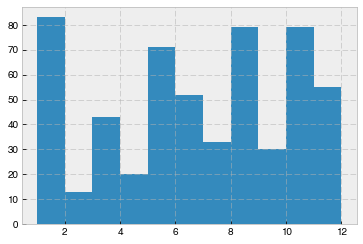

In [98]:
pitch_range = song_melody.normalized_pitch.max()-song_melody.normalized_pitch.min()
ax= song_melody.normalized_pitch.hist(bins=int(pitch_range))

In [100]:
pitches = song_melody.normalized_pitch.value_counts().nlargest(5).index
counts = song_melody.normalized_pitch.value_counts().nlargest(5).values
for i, c in zip(pitches, counts):
    print pretty_midi.note_number_to_name(i), " occurs ", c, " times"

C#-1  occurs  83  times
A#-1  occurs  79  times
G#-1  occurs  79  times
F-1  occurs  71  times
F#-1  occurs  52  times


what changed?

Root, Db4 still occurs the most (83)

The b7 and 5 tied for secondmost (79

Third, F4 occurs fourth most (71)

Fourth, Gb occurs quite a bit (52) - didn't show up in previous